# Investigating Median Salary Vs Skill for Data Analysts

### Methodology

1. Evaluate the top x paying skills for Data Analysts
2. Evaluate the x most in-demand skills for Data Analysts
3. Remove outlies from our dataset (<3 mentions)
4. Find the median salary for each skill
5. Visualise for most-in demand skills, and highest paying skills

In [2]:
# Importing libraries
import ast
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
import seaborn as sns

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x) # convert skill_list from str to list

In [3]:
# only interested in Data Analysts in the UK, so filter accordingly
df_da_uk = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'United Kingdom')].copy()

# drop any columns that conain NaN values for the yearly salary
df_da_uk = df_da_uk.dropna(subset=['salary_year_avg'])

In [4]:
# convert 'salary_year_avg' from usd to gbp, as we are studying data in the united kingdom
df_da_uk['salary_year_avg'] = df_da_uk['salary_year_avg'] * 0.77 # current exchange rate

In [5]:
# explode the dataframe on the 'job_skills' column so that each skill is its own row
df_da_uk = df_da_uk.explode('job_skills')

In [6]:
# find the top paying skills, by aggregating the relevant columns by their count and median respectively, then sorting by median and taking the top 10 values
# then filter for skills with count >= 3, sort by median, and take the top 10 values
df_da_top_pay = (df_da_uk.groupby('job_skills')['salary_year_avg']
                 .agg(['count', 'median'])
                 .query('count >= 3')  # keep only skills with 3 or more counts
                 .sort_values(by='median', ascending=False)
                 .head(10))

# investigate
df_da_top_pay

,count,median
job_skills,,
aws,3,127050.00
mysql,3,127050.00
sql server,4,101447.50
flow,4,88319.00
hadoop,3,85604.75
oracle,3,85604.75
jupyter,3,77385.00
powerpoint,3,77385.00
tableau,13,77385.00


In [7]:
# do the same as above for the most popular skills. so adjust code to sort by count instead of median
df_da_top_skills = df_da_uk.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False).head(10)

# want salaries in appropriate order for their associated skill, so now sort by median
df_da_top_skills = df_da_top_skills.sort_values(by='median', ascending=False)

# investigate
df_da_top_skills

,count,median
job_skills,,
tableau,13,77385.000
sql,33,75845.000
looker,6,73929.625
python,25,68607.000
power bi,7,68607.000
sas,8,61605.390
r,9,59303.475
excel,29,58173.500
go,9,54670.000


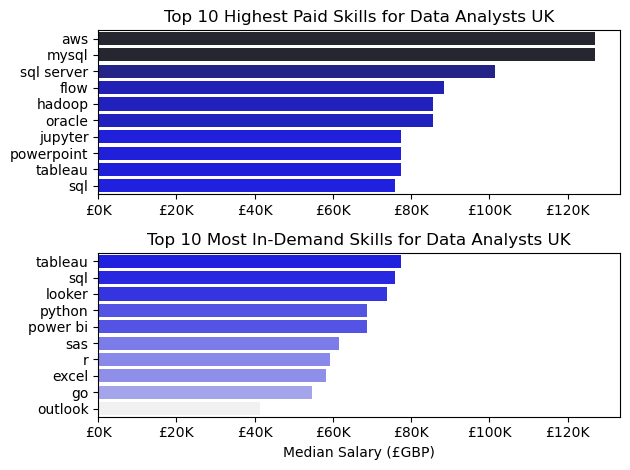

In [8]:
# generate a set of axes, 2 by 1
fig, ax = plt.subplots(2, 1)

# Top 10 Highest Paid Skills for Data Analysts
sns.barplot(data=df_da_top_pay, x='median', y=df_da_top_pay.index, ax=ax[0], hue='median', palette='dark:b_r')
ax[0].legend().remove()

ax[0].set_title('Top 10 Highest Paid Skills for Data Analysts UK')
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{int(x/1000)}K'))

# Top 10 Most In-Demand Skills for Data Analysts
sns.barplot(data=df_da_top_skills, x='median', y=df_da_top_skills.index, ax=ax[1], hue='median', palette='light:b')
ax[1].legend().remove()

#df_da_top_skills[::-1].plot(kind='barh', y='median', ax=ax[1], legend=False)
ax[1].set_title('Top 10 Most In-Demand Skills for Data Analysts UK')
ax[1].set_ylabel('')
ax[1].set_xlabel('Median Salary (£GBP)')
ax[1].set_xlim(ax[0].get_xlim()) # set the axes equal to eachother, ie: set the second axis equal to the limit of the first axis
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{int(x/1000)}K'))

plt.tight_layout()
plt.show()